# Matrix Formalism

In this example we will consider the matrix formalism approach for a geometry of cylinders.

In [1]:
using SpinDoctor
using LinearAlgebra

if haskey(ENV, "GITHUB_ACTIONS")
    using CairoMakie
else
    using GLMakie
end

setup = CylinderSetup(;
    name = "Slice",
    ncell = 3,
    rmin = 2.0,
    rmax = 6.0,
    dmin = 0.2,
    dmax = 0.3,
    height = 1.0,
    bend = 0.0,
    twist = 0.0,
    ecs_shape = :convex_hull,
    ecs_ratio = 0.5,
)

CylinderSetup{Float64}("Slice", "meshfiles", 3, 2.0, 6.0, 0.2, 0.3, 1.0, 0.0, 0.0, false, 0.5, :convex_hull, 0.5, Inf)

We also define coefficients for the different cell compartments `:in` (axon), `:out`
(myelin), and `:ecs` (ECS).

In [2]:
coeffs = coefficients(
    setup;
    D = (; in = 0.002 * I(3), out = 0.002 * I(3), ecs = 0.002 * I(3)),
    T₂ = (; in = Inf, out = Inf, ecs = Inf),
    ρ = (; in = 1.0, out = 1.0, ecs = 1.0),
    κ = (; in_out = 1e-4, out_ecs = 1e-4, in = 0.0, out = 0.0, ecs = 0.0),
    γ = 2.67513e-4,
)

(D = StaticArrays.SMatrix{3, 3, Float64, 9}[[0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002]], T₂ = [Inf, Inf, Inf, Inf], κ = [0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0], ρ = ComplexF64[1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im], γ = 0.000267513)

We then proceed to build the geometry and finite element mesh.

[ Info: Writing cell geometry to meshfiles/Slice_cells
Delaunizing vertices...
Delaunay seconds:  0.006951
Creating surface mesh ...
Surface mesh seconds:  0.001306
Constrained Delaunay...
Constrained Delaunay seconds:  0.001253
Removing exterior tetrahedra ...
Spreading region attributes.
Exterior tets removal seconds:  0.000138
Refining mesh...
Refinement seconds:  0.571977
Optimizing mesh...
Optimization seconds:  0.006928

Writing nodes.
Writing elements.
Writing faces.
Writing edges.

Output seconds:  0.000897
Total running seconds:  0.589559

Statistics:

  Input points: 254
  Input facets: 666
  Input segments: 380
  Input holes: 0
  Input regions: 4

  Mesh points: 4362
  Mesh tetrahedra: 22142
  Mesh faces: 45640
  Mesh faces on exterior boundary: 2712
  Mesh faces on input facets: 7896
  Mesh edges on input segments: 3741
  Steiner points on input facets:  254
  Steiner points on input segments:  3361
  Steiner points inside domain: 493

Delaunizing vertices...
Delaunay secon

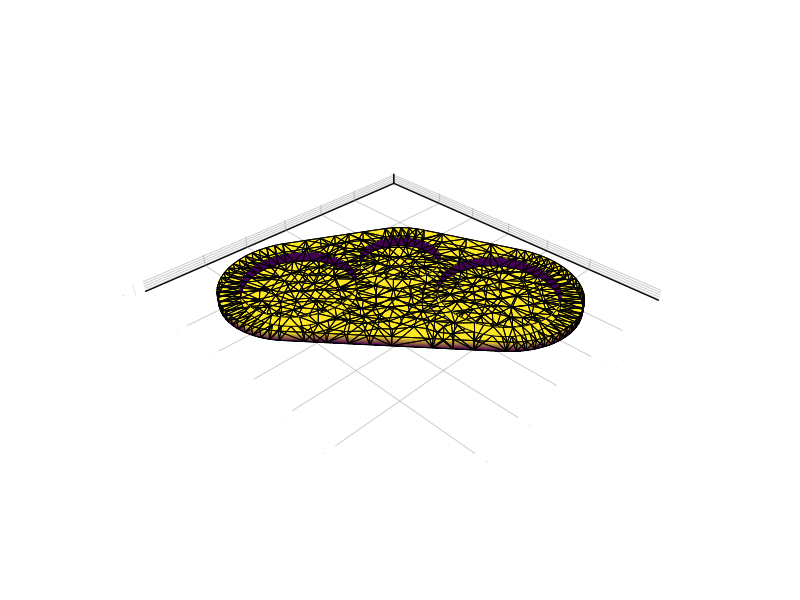

In [3]:
mesh, = create_geometry(setup; recreate = true)
plot_mesh(mesh)

The mesh looks good, so we may then proceed to assemble the biological model and the
associated finite element matrices.

In [4]:
model = Model(; mesh, coeffs...);
matrices = assemble_matrices(model);

We may also compute some useful quantities, including a scalar diffusion coefficient from
the diffusion tensors.

In [5]:
volumes = get_cmpt_volumes(model.mesh)
D_avg = 1 / 3 * tr.(model.D)' * volumes / sum(volumes)

0.002

The eigenfunctions of the diffusive part of the Bloch-Torrey operator forms a good basis
for the finite element function space. The basis may be truncated at a certain level, thus
reducing the number of degrees of freedom. We here opt for 400 eigenfunctions.

In [6]:
laplace = Laplace(; model, matrices, neig_max = 400)
lap_eig = solve(laplace)

┌ Info: Solving Laplace eigenvalue problem, computing 400 eigenvalues.
└ Problem size: 844 points.
┌ Warning: Obtained negative eigenvalues for Laplace operator.
│   findall(λ .< 0) =
│    1-element Vector{Int64}:
│     1
│   λ[λ .< 0] =
│    1-element Vector{Float64}:
│     -7.131203972055746e-17
└ @ SpinDoctor ~/work/SpinDoctor.jl/SpinDoctor.jl/src/matrix_formalism/solve_laplace.jl:33


(values = [-7.131203972055746e-17, 1.0944083564887725e-5, 2.720951810973174e-5, 4.3516012875173294e-5, 7.057877578083072e-5, 7.319768142412977e-5, 8.266380221081717e-5, 8.551455688733412e-5, 0.00013685671008739083, 0.00014907114688608302  …  0.03161015304276282, 0.03163014213600521, 0.03166910559303051, 0.03176936736039414, 0.03180667242111949, 0.031934584974930146, 0.03209538660614176, 0.03217059499762858, 0.03229093003688853, 0.03243254064157045], funcs = [0.04458922621146989 -0.00487684258359504 … -0.0034302846002483116 -4.47485706430701e-5; 0.04458922621146945 -0.004185299496131516 … 0.001366514537811762 -0.00031645497371301324; … ; 0.04458922621147894 -0.035545898138765235 … 0.06299610817000238 -9.071322749806647e-5; 0.04458922621147043 -0.024309044063894288 … -0.048351151825179156 -0.005637880894984904], moments = [[-0.5289927224900903 -5.4823078515660395 … -0.00035780794482626055 -0.0005371827976050538; -5.482307851566038 -0.06246407012083122 … -0.000717066010590961 -0.000516301

The resulting eigenvalues may be represented as length scales, describing the wavelength
of the eigenfunctions.

In [7]:
length_scales = eig2length.(lap_eig.values, D_avg)

400-element Vector{Float64}:
 Inf
 42.46930659922238
 26.934222618372665
 21.298073538112007
 16.723524470557916
 16.42162793700266
 15.452799935297472
 15.19304575283582
 12.00969070052804
 11.507157944427878
  ⋮
  0.7899767302151958
  0.7894906145341463
  0.7882438431620121
  0.7877814541497067
  0.7862021593994674
  0.784230204097214
  0.7833129813381049
  0.7818520760723774
  0.7801433035620317

We may also further truncate the eigenfunction basis, if we are satisfied skipping
features below a threshold length scale of 3 micrometers.

In [8]:
length_scale = 3
λ_max = length2eig(length_scale, D_avg)
lap_eig = limit_lengthscale(lap_eig, λ_max)

(values = [-7.131203972055746e-17, 1.0944083564887725e-5, 2.720951810973174e-5, 4.3516012875173294e-5, 7.057877578083072e-5, 7.319768142412977e-5, 8.266380221081717e-5, 8.551455688733412e-5, 0.00013685671008739083, 0.00014907114688608302  …  0.0016985964617060355, 0.0017329405723894372, 0.001995815609448489, 0.0020162538655219935, 0.0020429473694879574, 0.0020718189227790017, 0.0020816451155384573, 0.0021214477603791336, 0.0021508429540832777, 0.0021721031366726874], funcs = [0.04458922621146989 -0.00487684258359504 … 0.013712906077100047 -0.002325803045167456; 0.04458922621146945 -0.004185299496131516 … 0.0034836496254545784 0.0021761517736712164; … ; 0.04458922621147894 -0.035545898138765235 … 0.09658829417063594 0.038302305113427; 0.04458922621147043 -0.024309044063894288 … -0.06932121415443522 -0.08931052413933518], moments = [[-0.5289927224900903 -5.4823078515660395 … -0.013364900319705969 -0.02683524446915373; -5.482307851566038 -0.06246407012083122 … 0.003619014540326315 -0.0934

Each of the resulting eigenfunctions is represented in the same way as the initial
magnetization field `ρ`.

┌ Warning: Assignment to `nboundary` in soft scope is ambiguous because a global variable by the same name exists: `nboundary` will be treated as a new local. Disambiguate by using `local nboundary` to suppress this warning or `global nboundary` to assign to the existing global variable.
└ @ string:7


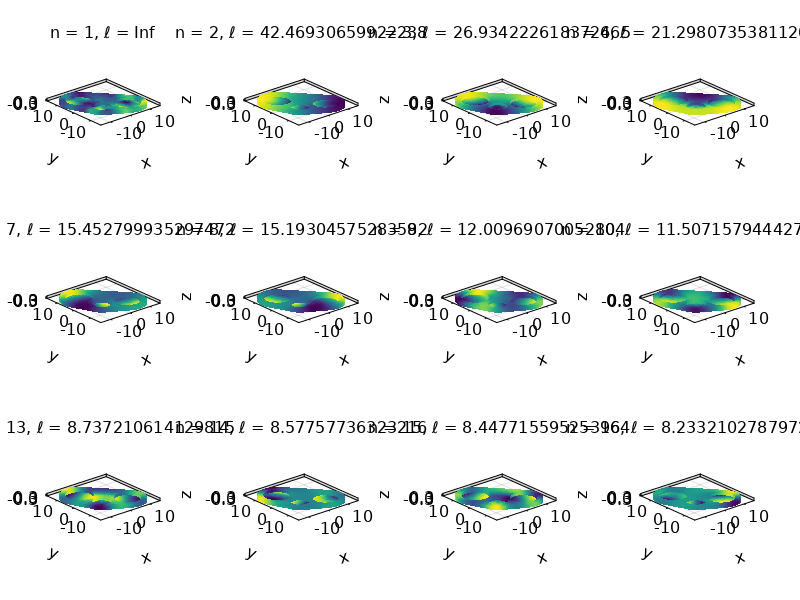

In [9]:
ncompartment, nboundary = size(mesh.facets)
fig = Figure()
for i = 1:3, j = 1:4
    ieig = 6(i - 1) + j
    ϕ_cmpts = split_field(mesh, lap_eig.funcs[:, ieig])
    ax = Axis3(fig[i, j]; title = "n = $ieig, ℓ = $(length_scales[ieig])", aspect = :data)
    nboundary = size(mesh.facets, 2)
    scene = nothing
    first = true
    for icmpt = 1:ncompartment, iboundary = 1:nboundary
        facets = mesh.facets[icmpt, iboundary]
        points = mesh.points[icmpt]
        mesh!(ax, points', facets', color = ϕ_cmpts[icmpt], shading = false)
    end
end
fig

We observe that the first functions have large features, while the higher-index functions
have more rapidly varying features. We may now choose a gradient and compute the
projection of magnetization field onto the truncated basis.

In [10]:
dir = [1.0, 0.0, 0.0]
profile = CosOGSE(5000.0, 5000.0, 2)
b = 1000
g = √(b / int_F²(profile)) / coeffs.γ
gradient = ScalarGradient(dir, profile, g)

ScalarGradient{Float64}([1.0, 0.0, 0.0], CosOGSE{Float64}(5000.0, 5000.0, 2), 4.201554156121445)

The matrix formalism problem is solved in the same way as the `BTPDE`. The time
profile is approximated on 500 points, since it is non-constant.

In [11]:
mf = MatrixFormalism(; model, matrices, lap_eig)
ξ = solve(mf, gradient; ninterval = 500)

844-element Vector{ComplexF64}:
  0.2324674615655686 + 0.01850811768519695im
 0.22846671249748685 + 0.01780640935963678im
  0.2228928303649757 + 0.01694139263720989im
 0.21573005373043652 + 0.014951257406953904im
 0.20770314301260892 + 0.010665899969625164im
 0.20057299579123702 + 0.004773754039311524im
 0.19430717280112905 - 0.0017427698176066854im
 0.19265234410857926 - 0.007720970828315131im
 0.19386441962304424 - 0.012187916836312795im
  0.1972135490658345 - 0.015840949910925554im
                     ⋮
 0.21042827008059972 - 0.011024487489941531im
 0.21997644008329587 + 0.0010566011709526187im
  0.2200964771578217 + 0.0009444819233333335im
 0.20161758097808025 - 0.016839530006392805im
 0.20500274728039347 - 0.014578018073693216im
 0.23211083411366187 + 0.0021032106153960417im
 0.24686445749474015 + 0.012963862413803186im
 0.23176624869975446 + 0.002413791797546608im
 0.19961684686498504 - 0.019620863092363976im

The resulting magnetization field may be plotted.

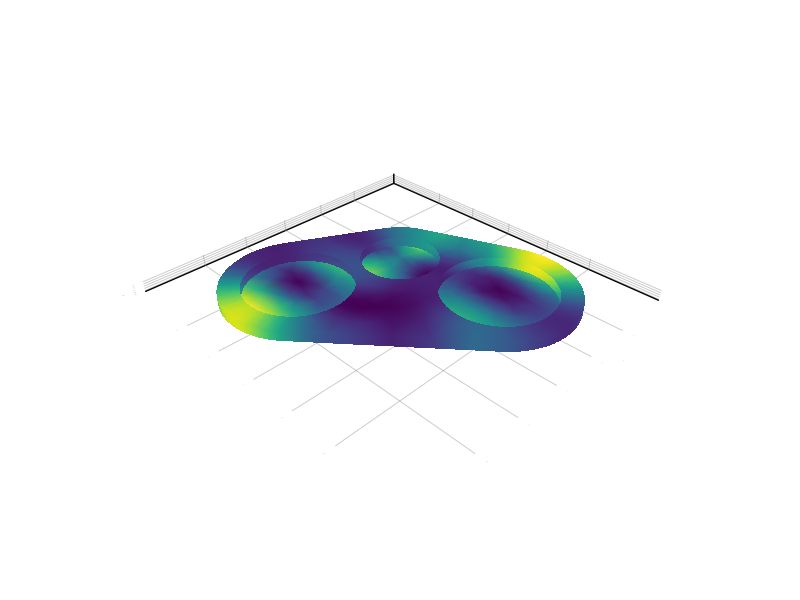

In [12]:
plot_field(model.mesh, ξ)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*